In [2]:
import pandas as pd
from transformers import AutoTokenizer

In [3]:
df = pd.read_csv('lt_1024_data.csv')
df.shape

(91788, 3)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

# count tokens for abstracts and titles
df['abstract_tokens'] = df['abstract'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['title_tokens'] = df['title'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [5]:
mask = (df['abstract_tokens'].between(128, 512)) & (df['title_tokens'].between(8, 32))
filtered_df = df[mask]
filtered_df.shape

(76792, 5)

# Splitting data

Ratio of Train - Validation - Test sets accordingly: **80 : 10 : 10**

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets
train_df, temp_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Split the temp set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display the sizes of the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 61433
Validation set size: 7679
Test set size: 7680


# How's the distribution on all 3 sets?

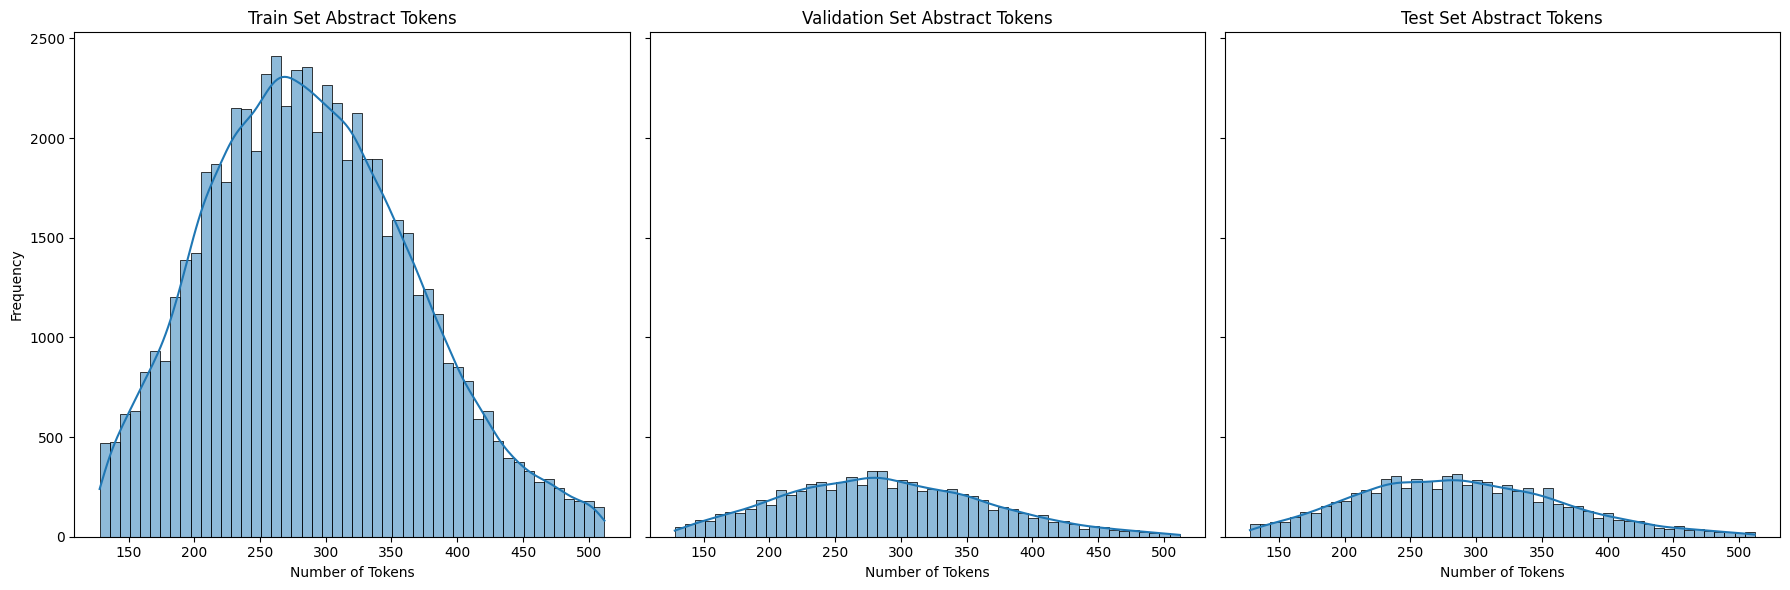

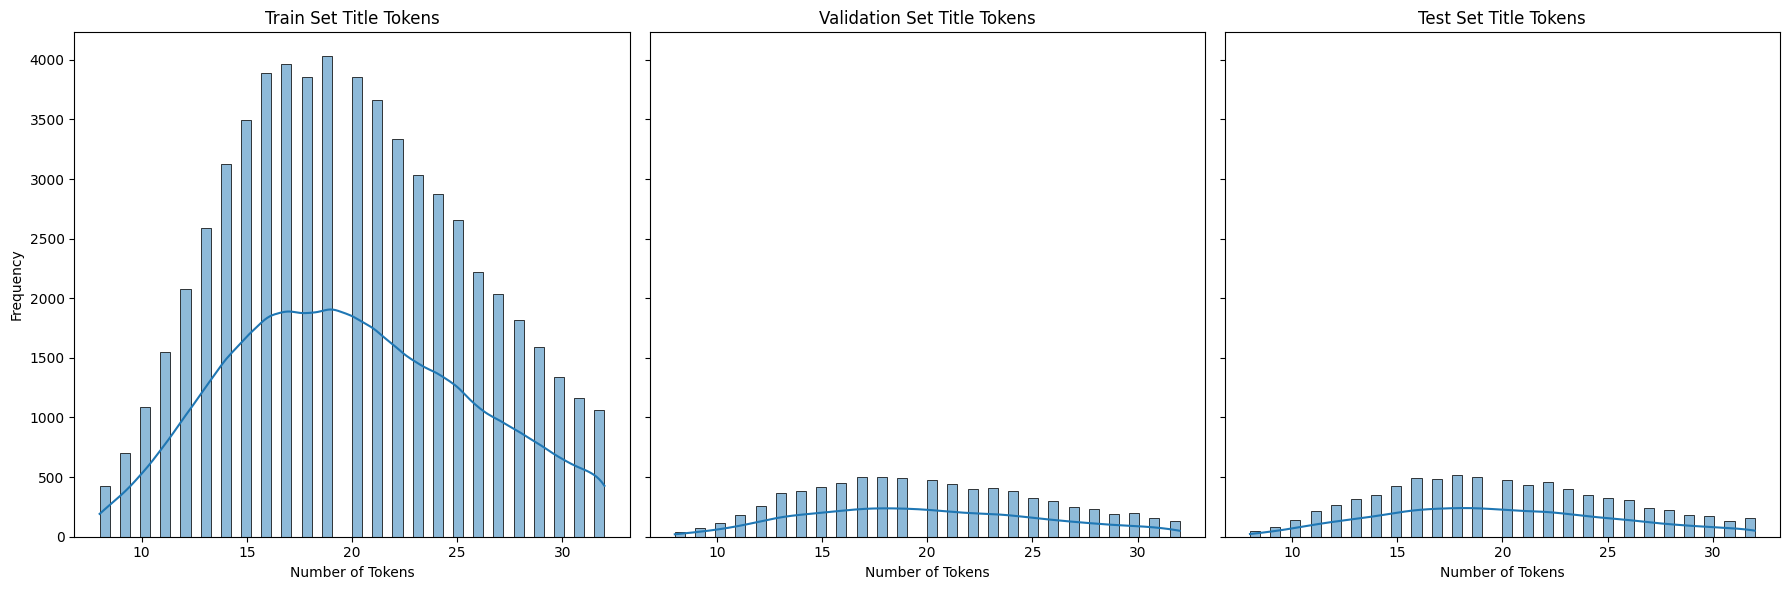

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(train_df['abstract_tokens'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Train Set Abstract Tokens')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

sns.histplot(val_df['abstract_tokens'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Validation Set Abstract Tokens')
axes[1].set_xlabel('Number of Tokens')

sns.histplot(test_df['abstract_tokens'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Test Set Abstract Tokens')
axes[2].set_xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(train_df['title_tokens'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Train Set Title Tokens')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

sns.histplot(val_df['title_tokens'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Validation Set Title Tokens')
axes[1].set_xlabel('Number of Tokens')

sns.histplot(test_df['title_tokens'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Test Set Title Tokens')
axes[2].set_xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

#### **All 3 sets resemble Standard distribution**

In [9]:

# Save the data
import os


os.makedirs("data", exist_ok=True)

def drop_n_save(df, type):
    df.columns
    cols = ['abstract_tokens', 'title_tokens']
    df.drop(cols,axis=1, inplace=True)
    df.to_csv(f"./data/{type}.csv", index=False)

drop_n_save(train_df, "train")
drop_n_save(val_df, "validation")
drop_n_save(test_df, "test")

# Bigrams and Trigrams distribution

We will be looking for differences in distribution of bigrams and trigrams in all 3 sets.
- If the distribution is similar, it means that the data is split randomly.
- If the distribution is different, it means that the data is split in a biased way. Which means it needs to be split again in a different way.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import seaborn as sns

# Function to get top n-grams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def visualize_top_ngrams(df, n=10):
    # Get top 20 bigrams and trigrams
    top_bigrams = get_top_ngrams(df['abstract'], n=n, ngram_range=(2, 2))
    top_trigrams = get_top_ngrams(df['abstract'], n=n, ngram_range=(3, 3))

    # Convert to DataFrame for visualization
    bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
    trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])
        
    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot bigrams
    sns.barplot(x='Frequency', y='Bigram', data=bigrams_df, ax=axs[0])
    axs[0].set_title(f'Top {n} Bigrams')

    # Plot trigrams
    sns.barplot(x='Frequency', y='Trigram', data=trigrams_df, ax=axs[1])
    axs[1].set_title(f'Top {n} Trigrams')

    plt.tight_layout()
    plt.show()

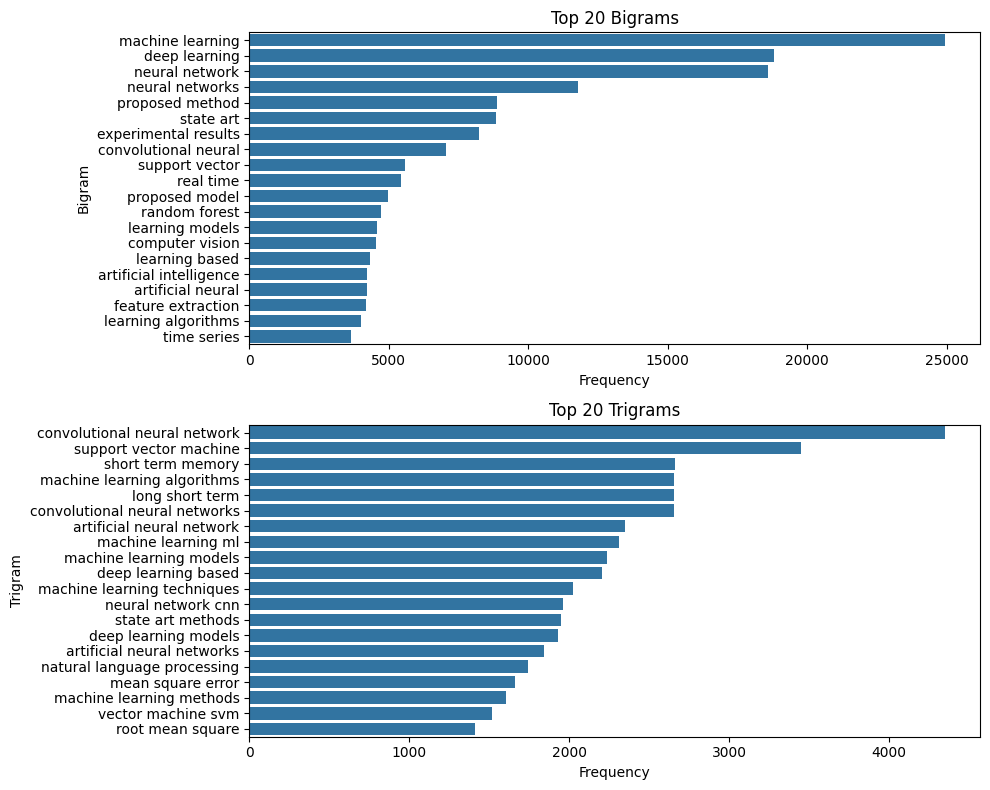

In [11]:
visualize_top_ngrams(train_df, 20)

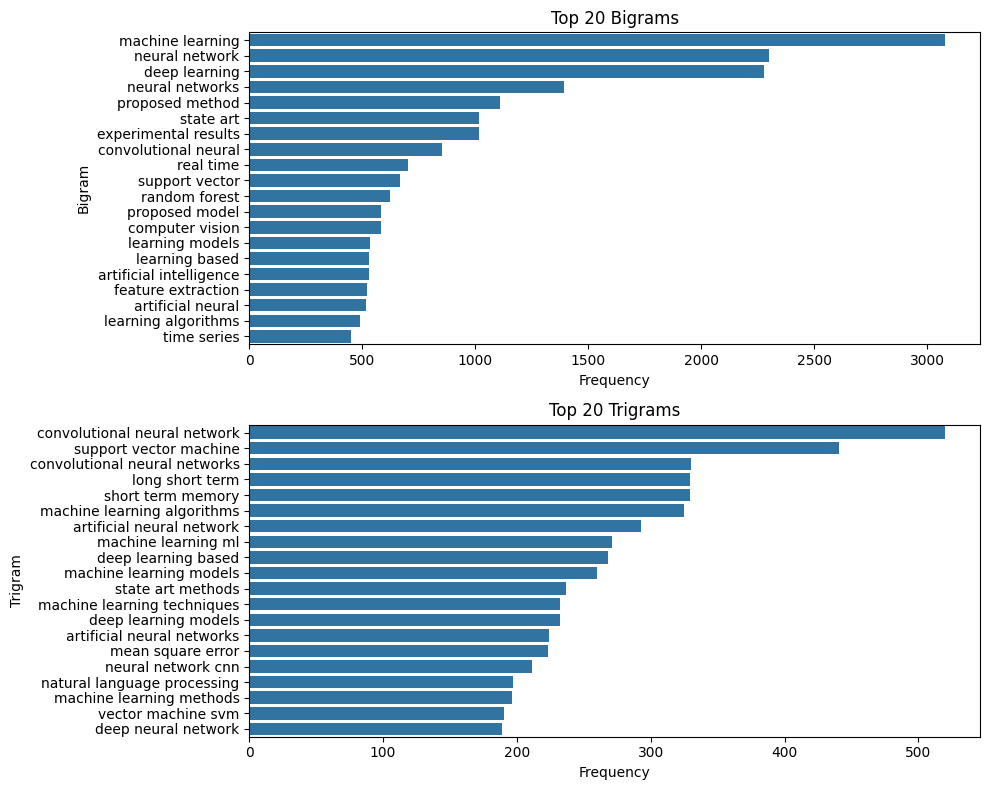

In [12]:
visualize_top_ngrams(val_df, 20)

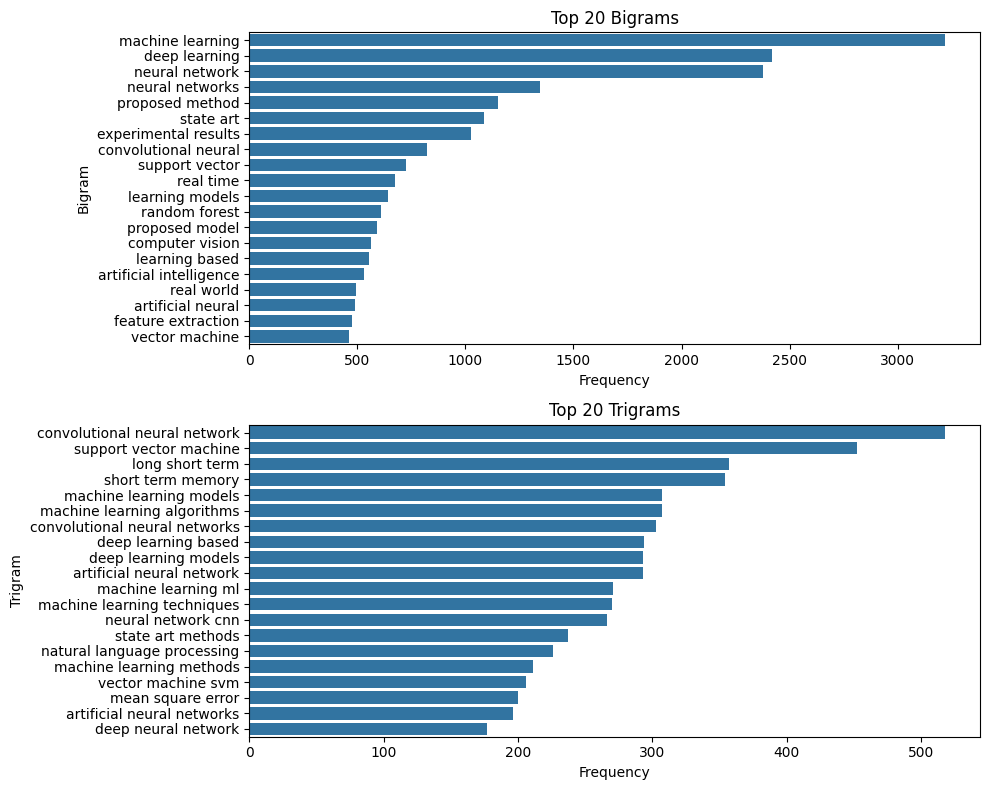

In [13]:
visualize_top_ngrams(test_df, 20)

### **Bigrams and Trigrams distribution in all 3 sets are mostly similar, it is safe**